In [39]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from gensim.corpora import Dictionary
import string
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import LSTM
from sklearn.metrics import roc_auc_score,roc_curve, auc, confusion_matrix, precision_score, recall_score,f1_score
import boto3
import pickle
import os
import datetime
import seaborn as sns

In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
s3 = boto3.client('s3')
response = s3.list_buckets()

In [4]:
response

{'ResponseMetadata': {'RequestId': 'VD9XSE87M2CTJNTP',
  'HostId': 'goLhojrndRgZJXfc2+S+twei53XlIP1QKMIEBxHGh5Kr8M7QpFSWKQp5ZUltZyM37dDlCTELkXg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'goLhojrndRgZJXfc2+S+twei53XlIP1QKMIEBxHGh5Kr8M7QpFSWKQp5ZUltZyM37dDlCTELkXg=',
   'x-amz-request-id': 'VD9XSE87M2CTJNTP',
   'date': 'Thu, 25 Jan 2024 20:14:49 GMT',
   'content-type': 'application/xml',
   'transfer-encoding': 'chunked',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'Buckets': [{'Name': 'aws-glue-assets-467245099071-us-east-1',
   'CreationDate': datetime.datetime(2024, 1, 13, 13, 35, 34, tzinfo=tzlocal())},
  {'Name': 'aws-logs-467245099071-us-east-1',
   'CreationDate': datetime.datetime(2024, 1, 13, 14, 43, 33, tzinfo=tzlocal())},
  {'Name': 'projekt-athena-dq',
   'CreationDate': datetime.datetime(2024, 1, 13, 13, 54, tzinfo=tzlocal())},
  {'Name': 'projekt-flink',
   'CreationDate': datetime.datetime(2024, 1, 25, 18, 27, 36, tzinfo=tzlocal())},
  {'Name': 'p

In [5]:
s3 = boto3.resource('s3')
obj = s3.Object(bucket_name='projekt-landing-zone', key='part-01.json')
response = obj.get()
data = response['Body'].read()

In [6]:
json_test = json.loads(data)

In [7]:
df_pd = pd.DataFrame(json_test)

In [8]:
df_pd

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful
0,rw5704482,raeldor-96879,After Life (2019– ),9,Very Strong Season 2,3 May 2020,0,"I enjoyed the first season, but I must say I t...","[1, 1]"
1,rw5704483,dosleeb,The Valhalla Murders (2019– ),6,Icelandic detectives?,3 May 2020,0,I know Iceland is a small country and police d...,"[2, 2]"
2,rw5704484,brightconscious,Special OPS (2020– ),7,Nothing special,3 May 2020,0,"Except K K , no other actor looks comfortable ...","[0, 0]"
3,rw5704485,gasconyway,#BlackAF (2020– ),8,Good but,3 May 2020,0,I'm guessing that as a 62 year old white woman...,"[5, 9]"
4,rw5704487,mmason-15867,The Droving (2020),2,An honest review,3 May 2020,0,Here's the truth. There's not much to this mov...,"[26, 41]"
...,...,...,...,...,...,...,...,...,...
1010288,rw0982994,backseat-2,Flight of the Phoenix (2004),3,What a waste,21 December 2004,1,The original Flight of the Phoenix is a classi...,"[16, 31]"
1010289,rw0982996,Sunshine95,A Series of Unfortunate Events (2004),10,Lots of Comedy,21 December 2004,1,Lemony Snickets was a Great movie because of t...,"[2, 3]"
1010290,rw0982997,ComeAsYouAre91,The Matrix (1999),8,Why Hate It???,21 December 2004,0,When The Matrix came out I was only twelve yea...,"[1, 3]"
1010291,rw0982998,skyymelonpeace44-1,Elf (2003),8,Best Christmas movie for kids,21 December 2004,0,I think the movie was really good.Its a kids m...,"[1, 4]"


In [9]:
df_pd.dtypes

review_id         object
reviewer          object
movie             object
rating            object
review_summary    object
review_date       object
spoiler_tag        int64
review_detail     object
helpful           object
dtype: object

In [10]:
df_pd.isna().sum()

review_id             0
reviewer              0
movie                 0
rating            51520
review_summary        0
review_date           0
spoiler_tag           0
review_detail         0
helpful               0
dtype: int64

In [11]:
df_pd1 = df_pd.copy()
df_pd1['rating'] = df_pd['rating'].fillna(np.nan).astype('float64')
df_pd1['helpful_0'] = df_pd['helpful'].apply(lambda x: x[0]).str.replace(",","").astype('int64')
df_pd1['helpful_1'] = df_pd['helpful'].apply(lambda x: x[1]).str.replace(",","").astype('int64')
df_pd1['helpful_perc'] = df_pd1['helpful_0']/df_pd1['helpful_1']
df_pd1['review_dt'] = pd.to_datetime(df_pd['review_date'],format="%d %B %Y")
df_pd1['review_year'] = df_pd1['review_dt'].dt.to_period('Y')
df_pd1['review_month'] = df_pd1['review_dt'].dt.to_period('M')
df_pd1['movie_year'] = df_pd['movie'].str.extract(r"\((\d+[^\)]*)\)[^\(]*$",expand=False).str.extract(r"(\d+)",expand=False).astype('float64')

In [12]:
df_pd1.head()

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful,helpful_0,helpful_1,helpful_perc,review_dt,review_year,review_month,movie_year
0,rw5704482,raeldor-96879,After Life (2019– ),9.0,Very Strong Season 2,3 May 2020,0,"I enjoyed the first season, but I must say I t...","[1, 1]",1,1,1.000000,2020-05-03,2020,2020-05,2019.0
1,rw5704483,dosleeb,The Valhalla Murders (2019– ),6.0,Icelandic detectives?,3 May 2020,0,I know Iceland is a small country and police d...,"[2, 2]",2,2,1.000000,2020-05-03,2020,2020-05,2019.0
2,rw5704484,brightconscious,Special OPS (2020– ),7.0,Nothing special,3 May 2020,0,"Except K K , no other actor looks comfortable ...","[0, 0]",0,0,NaN,2020-05-03,2020,2020-05,2020.0
3,rw5704485,gasconyway,#BlackAF (2020– ),8.0,Good but,3 May 2020,0,I'm guessing that as a 62 year old white woman...,"[5, 9]",5,9,0.555556,2020-05-03,2020,2020-05,2020.0
4,rw5704487,mmason-15867,The Droving (2020),2.0,An honest review,3 May 2020,0,Here's the truth. There's not much to this mov...,"[26, 41]",26,41,0.634146,2020-05-03,2020,2020-05,2020.0


In [13]:
df_pd1.dtypes

review_id                 object
reviewer                  object
movie                     object
rating                   float64
review_summary            object
review_date               object
spoiler_tag                int64
review_detail             object
helpful                   object
helpful_0                  int64
helpful_1                  int64
helpful_perc             float64
review_dt         datetime64[ns]
review_year        period[A-DEC]
review_month           period[M]
movie_year               float64
dtype: object

### Przygotowujemy słownik do mapowania tokenów na liczby naturalne

In [14]:
tokens_in_dataset = 5000
document_max_len = 400
batch_size0 = 10000
batch_size = 32
embedding_dim = 64

punc = string.punctuation
dct = Dictionary()

def wt(string):
    return [w.lower() for w in word_tokenize(string)
                if w.lower() not in punc]

In [15]:
x = df_pd1['review_detail']
y = df_pd1['spoiler_tag']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=12)

In [16]:
y_train

157926    0
634635    0
226955    0
748172    0
118159    0
         ..
564465    0
412925    0
255366    0
759451    0
472907    0
Name: spoiler_tag, Length: 707205, dtype: int64

In [17]:
path_out = 'processed_batches/'
path_out_x_train = path_out + 'x_train/'
path_out_y_train = path_out + 'y_train/'
path_out_x_test = path_out + 'x_test/'
path_out_y_test = path_out + 'y_test/'

if not(os.path.exists(path_out)):
    os.mkdir(path_out)
if not(os.path.exists(path_out_x_train)):
    os.mkdir(path_out_x_train)
if not(os.path.exists(path_out_y_train)):
    os.mkdir(path_out_y_train)
if not(os.path.exists(path_out_x_test)):
    os.mkdir(path_out_x_test)
if not(os.path.exists(path_out_y_test)):
    os.mkdir(path_out_y_test)

In [18]:
def preprocess_batch(batch_size,batch_i,data_x,data_y,dct,output_loc_x,output_loc_y):
    x_batch = data_x.iloc[(batch_i*batch_size):((batch_i+1)*batch_size)]
    y_batch = data_y.iloc[(batch_i*batch_size):((batch_i+1)*batch_size)]
    review_detail_clear = x_batch.apply(wt)
    dct.add_documents(review_detail_clear)
    review_detail_idx = review_detail_clear.apply(lambda x: [y%tokens_in_dataset 
                                                         for y in dct.doc2idx(x)])
    padded_seq = sequence.pad_sequences(review_detail_idx, maxlen=document_max_len, padding='pre', truncating='post')
    with open(f"{output_loc_x}x_{batch_i}.pickle","wb") as f:
        pickle.dump(padded_seq,f)
    with open(f"{output_loc_y}y_{batch_i}.pickle","wb") as f:
        pickle.dump(y_batch,f)
    return dct

In [19]:
n_batch0_train = int(np.ceil(x_train.shape[0]/batch_size0))

for i in range(n_batch0_train):
    print(f"{datetime.datetime.now()} Processing training set - batch {i+1}/{n_batch0_train}")
    dct = preprocess_batch(batch_size0,i,x_train,y_train,dct,path_out_x_train,path_out_y_train)

n_batch0_test = int(np.ceil(x_test.shape[0]/batch_size0))

for i in range(n_batch0_test):
    print(f"{datetime.datetime.now()} Processing test set - batch {i+1}/{n_batch0_test}")
    dct = preprocess_batch(batch_size0,i,x_test,y_test,dct,path_out_x_test,path_out_y_test)

2024-01-25 20:16:39.107783 Processing training set - batch 1/71
2024-01-25 20:16:46.317982 Processing training set - batch 2/71
2024-01-25 20:16:53.425021 Processing training set - batch 3/71
2024-01-25 20:17:00.458556 Processing training set - batch 4/71
2024-01-25 20:17:07.607609 Processing training set - batch 5/71
2024-01-25 20:17:14.821254 Processing training set - batch 6/71
2024-01-25 20:17:22.067103 Processing training set - batch 7/71
2024-01-25 20:17:29.347814 Processing training set - batch 8/71
2024-01-25 20:17:36.734395 Processing training set - batch 9/71
2024-01-25 20:17:43.988680 Processing training set - batch 10/71
2024-01-25 20:17:51.416039 Processing training set - batch 11/71
2024-01-25 20:17:58.639798 Processing training set - batch 12/71
2024-01-25 20:18:06.074192 Processing training set - batch 13/71
2024-01-25 20:18:13.510552 Processing training set - batch 14/71
2024-01-25 20:18:20.798160 Processing training set - batch 15/71
2024-01-25 20:18:28.054945 Process

In [20]:
model = Sequential()

model.add(Embedding(input_dim=tokens_in_dataset, # liczba unikalnych tokenów
                    output_dim=embedding_dim, # wielkość embeddingu
                    input_length=document_max_len, # długość sekwencji
                    ))
model.add(LSTM(units=32, activation='tanh', return_sequences=True))
model.add(LSTM(units=16, activation='tanh', return_sequences=False))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

es = EarlyStopping(patience=3, monitor='val_loss')
model.summary()

2024-01-25 20:30:28.070474: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-01-25 20:30:28.070498: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-25 20:30:28.070521: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-81-61): /proc/driver/nvidia/version does not exist
2024-01-25 20:30:28.070738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 64)           320000    
                                                                 
 lstm (LSTM)                 (None, 400, 32)           12416     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 335,841
Trainable params: 335,841
Non-trainable params: 0
_________________________________________________________________


In [21]:
n_epochs = 2

for j in range(n_epochs):
    print(f"Epoch {j+1}/{n_epochs}")
    for i in range(n_batch0_train):
        print(f"{datetime.datetime.now()} Training - batch {i+1}/{n_batch0_train}")
        with open(f"{path_out_x_train}x_{i}.pickle","rb") as f:
            x_train_batch = pickle.load(f)
        with open(f"{path_out_y_train}y_{i}.pickle","rb") as f:
            y_train_batch = pickle.load(f)
        model.fit(x_train_batch, y_train_batch, batch_size=batch_size,
          verbose=1,
          validation_split=0.2,
          epochs=1)

Epoch 1/2
2024-01-25 20:30:30.127783 Training - batch 1/71


/home/ubuntu/my_env/lib/python3.10/site-packages/keras/engine/data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


250/250 [==============================] - 36s 139ms/step - loss: 0.4785 - accuracy: 0.8106 - val_loss: 0.4287 - val_accuracy: 0.8105
2024-01-25 20:31:06.404394 Training - batch 2/71
250/250 [==============================] - 34s 136ms/step - loss: 0.4346 - accuracy: 0.8148 - val_loss: 0.4519 - val_accuracy: 0.8190
2024-01-25 20:31:40.552044 Training - batch 3/71
250/250 [==============================] - 34s 135ms/step - loss: 0.4312 - accuracy: 0.8130 - val_loss: 0.4335 - val_accuracy: 0.8155
2024-01-25 20:32:14.308748 Training - batch 4/71
250/250 [==============================] - 34s 135ms/step - loss: 0.4597 - accuracy: 0.8100 - val_loss: 0.4541 - val_accuracy: 0.8000
2024-01-25 20:32:48.120881 Training - batch 5/71
250/250 [==============================] - 34s 136ms/step - loss: 0.4427 - accuracy: 0.8112 - val_loss: 0.4292 - val_accuracy: 0.8210
2024-01-25 20:33:22.141291 Training - batch 6/71
250/250 [==============================] - 34s 135ms/step - loss: 0.4310 - accuracy: 

In [22]:
if not(os.path.exists('model/')):
    os.mkdir('model/')

In [23]:
model.save('model/lstm.keras')

In [24]:
prob_pred_test_batch = []

for i in range(n_batch0_test):
    print(f"{datetime.datetime.now()} Prediction - test set - batch {i+1}/{n_batch0_test}")
    with open(f"{path_out_x_test}x_{i}.pickle","rb") as f:
        x_test_batch = pickle.load(f)
    prob_pred_test_batch.append(model.predict(x_test_batch))

prob_pred_test = np.concatenate(prob_pred_test_batch)

2024-01-25 22:00:36.946506 Prediction - test set - batch 1/31
313/313 [==============================] - 11s 34ms/step
2024-01-25 22:00:47.998770 Prediction - test set - batch 2/31
313/313 [==============================] - 11s 34ms/step
2024-01-25 22:00:58.607968 Prediction - test set - batch 3/31
313/313 [==============================] - 11s 35ms/step
2024-01-25 22:01:19.110040 Prediction - test set - batch 4/31
313/313 [==============================] - 11s 34ms/step
2024-01-25 22:01:39.613692 Prediction - test set - batch 5/31
313/313 [==============================] - 11s 34ms/step
2024-01-25 22:02:00.117837 Prediction - test set - batch 6/31
313/313 [==============================] - 11s 34ms/step
2024-01-25 22:02:20.622098 Prediction - test set - batch 7/31
313/313 [==============================] - 10s 33ms/step
2024-01-25 22:02:41.121893 Prediction - test set - batch 8/31
313/313 [==============================] - 11s 34ms/step
2024-01-25 22:03:01.622615 Prediction - test set

In [25]:
prob_pred_train_batch = []

for i in range(n_batch0_train):
    print(f"{datetime.datetime.now()} Prediction - train set - batch {i+1}/{n_batch0_train}")
    with open(f"{path_out_x_train}x_{i}.pickle","rb") as f:
        x_train_batch = pickle.load(f)
    prob_pred_train_batch.append(model.predict(x_train_batch))

prob_pred_train = np.concatenate(prob_pred_train_batch)

2024-01-25 22:09:51.845611 Prediction - train set - batch 1/71
313/313 [==============================] - 12s 38ms/step
2024-01-25 22:10:12.348492 Prediction - train set - batch 2/71
313/313 [==============================] - 11s 35ms/step
2024-01-25 22:10:32.849217 Prediction - train set - batch 3/71
313/313 [==============================] - 11s 35ms/step
2024-01-25 22:10:43.736324 Prediction - train set - batch 4/71
313/313 [==============================] - 11s 34ms/step
2024-01-25 22:11:04.240361 Prediction - train set - batch 5/71
313/313 [==============================] - 12s 37ms/step
2024-01-25 22:11:24.740712 Prediction - train set - batch 6/71
313/313 [==============================] - 11s 35ms/step
2024-01-25 22:11:45.247159 Prediction - train set - batch 7/71
313/313 [==============================] - 11s 35ms/step
2024-01-25 22:11:56.405993 Prediction - train set - batch 8/71
313/313 [==============================] - 12s 38ms/step
2024-01-25 22:12:16.903159 Prediction - 

In [26]:
AUC = {
       'train': roc_auc_score(y_train,prob_pred_train),
       'test': roc_auc_score(y_test,prob_pred_test),
       }

print(AUC)

{'train': 0.8266767190338987, 'test': 0.8091864672138632}


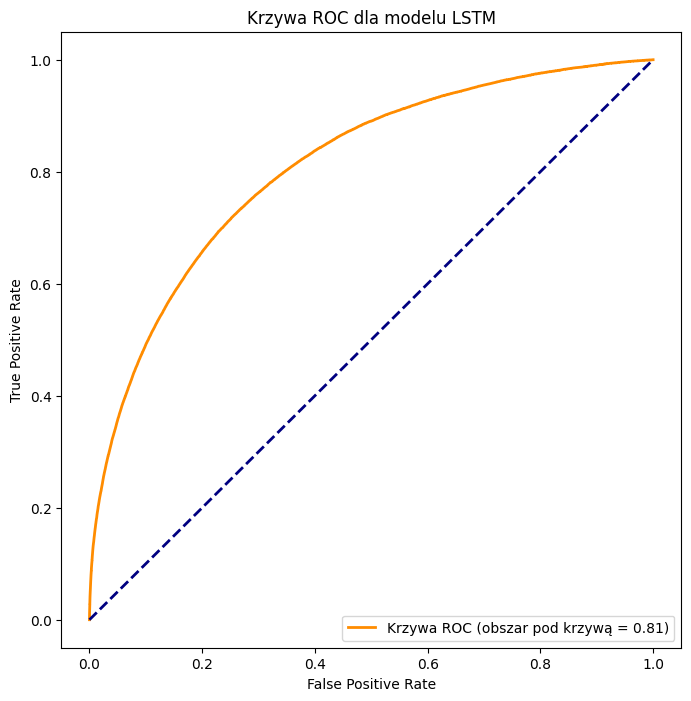

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, prob_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (obszar pod krzywą = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Krzywa ROC dla modelu LSTM')
plt.legend(loc='lower right')
plt.show()

In [64]:
n_iter = 101
rates = np.linspace(0,1,n_iter)
y_test0 = np.array(y_test).reshape(-1,1)
acc = np.zeros(n_iter)
prec = np.zeros(n_iter)
rec = np.zeros(n_iter)
f1 = np.zeros(n_iter)
for i in range(rates.shape[0]):
    print(f"{i}",end="\r")
    y_pred_test_r = (prob_pred_test > rates[i]).astype(int)
    acc[i] = np.mean(np.equal(y_test0,y_pred_test_r))
    prec[i] = precision_score(y_test0,y_pred_test_r)
    rec[i] = recall_score(y_test0,y_pred_test_r)
    f1[i] = f1_score(y_test0,y_pred_test_r)

/home/ubuntu/my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/my_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


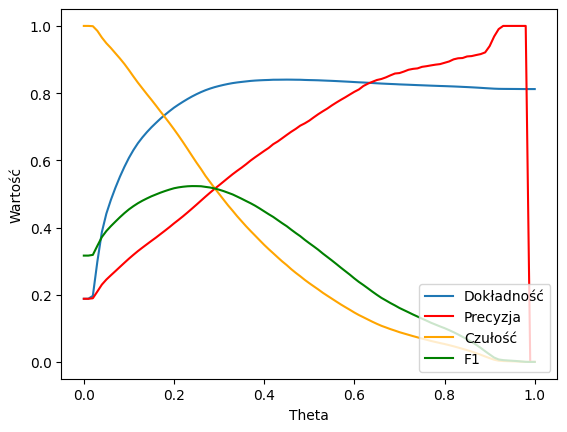

In [68]:
plt.plot(rates, acc,label='Dokładność')
plt.plot(rates, prec,'red',label='Precyzja')
plt.plot(rates, rec,'orange',label='Czułość')
plt.plot(rates, f1,'green',label='F1')
plt.xlabel('Theta')
plt.ylabel('Wartość')
plt.legend(loc='lower right')
plt.show()

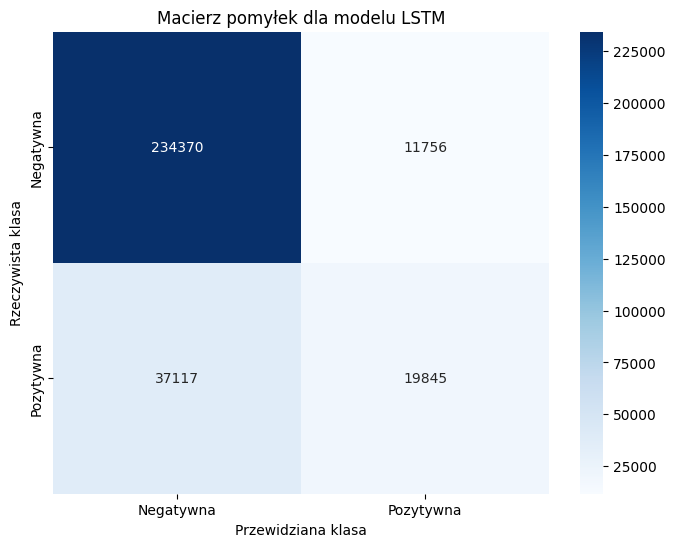

In [69]:
rate = 0.4
y_pred_test = (prob_pred_test > rate).astype(int)

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negatywna", "Pozytywna"], yticklabels=["Negatywna", "Pozytywna"])
plt.xlabel('Przewidziana klasa')
plt.ylabel('Rzeczywista klasa')
plt.title('Macierz pomyłek dla modelu LSTM')
plt.show()

In [70]:
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

print(precision, recall, f1)

0.6279864561248062 0.3483901548400688 0.4481555502862369
